In [1]:
import numpy as np
import datetime
from numpy import ndarray
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, models, preprocessing
from tensorflow.keras.callbacks import TensorBoard
import torch
from tensorflow.keras.datasets import cifar10, imdb
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix , RocCurveDisplay
import torch.nn as nn 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import cv2
from collections import Counter
from tqdm.auto import tqdm

### Deep Learning fundamentals with TensorFlow, Keras, and PyTorch

#### Data representation for neural networks

Data stored in multidimensional NumPy arrays (tensors). It is a container for numerical data.
For instance, matrices are rank-2 tensors; tensors are a generalization of matrices to an arbitrary number of dimensions


In [2]:
# Define a function to print an object and its ndim/shape
def array_info(x):
    print(f'The object:\n{x}')
    print(f'Has {x.ndim} dimension(s)')
    print(f'And has {x.shape} shape')

In [3]:
# Scalar
x = np.array(77)
array_info(x)

The object:
77
Has 0 dimension(s)
And has () shape


In [4]:
# Vector
x = np.random.randint(40, size=10)
array_info(x)

The object:
[29 35 10 29 32 21 21  7 23 32]
Has 1 dimension(s)
And has (10,) shape


In [5]:
# Matrix
x = np.random.randint(100, size=(4, 6))
array_info(x)

The object:
[[78 57  5 99 94 77]
 [74  3 58 57 83 72]
 [41 78  9 49 38 52]
 [67 96  7 71  3 79]]
Has 2 dimension(s)
And has (4, 6) shape


In [6]:
# Tensor
x = np.random.randint(100, size=(4, 3, 5))
array_info(x)

The object:
[[[38  4 33 82 46]
  [26 29 24 34 27]
  [30 55  8 40 74]]

 [[33 77 83 34 62]
  [52 85 24 23 31]
  [32 14 31 26 51]]

 [[31 34 36 92 63]
  [ 5 97 71 41 76]
  [80 81 80 93 96]]

 [[31 71 12 66 58]
  [66 11 24  6 62]
  [37 57 54 68 18]]]
Has 3 dimension(s)
And has (4, 3, 5) shape


In [7]:
# Manipulations with tensors using numpy 

In [8]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [20]:
image = train_images[2:6]

In [9]:
train_images.shape

(50000, 32, 32, 3)

In [109]:
sliced = train_images[10:30]

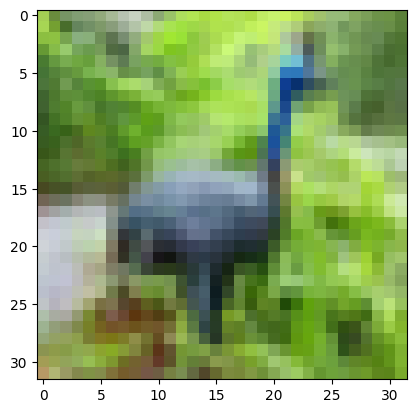

In [11]:
image = train_images[6]
plt.imshow(image)
plt.show()

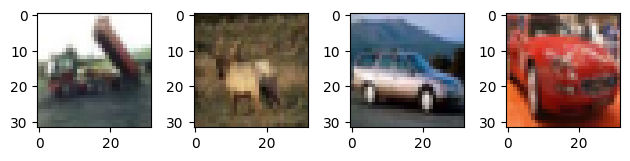

In [162]:
sliced = train_images[2:6]
fig, ax = plt.subplots(1, 4)
for i, obj in enumerate(ax):
    obj.imshow(sliced[i])
plt.tight_layout()
plt.show()

In [163]:
sliced.shape

(4, 32, 32, 3)

In [164]:
sliced[1,:,:,1]

array([[25, 34, 35, ..., 67, 72, 76],
       [28, 30, 27, ..., 82, 82, 72],
       [32, 33, 50, ..., 76, 89, 77],
       ...,
       [73, 77, 74, ..., 93, 84, 75],
       [72, 74, 77, ..., 74, 70, 76],
       [78, 75, 75, ..., 47, 56, 65]], dtype=uint8)

### Neural networks

Neural networks are powerful function approximators and can be visualized as a graph. They utilize a graph structure to represent a sequence of computational steps that map an input feature vector to an output value, which is commonly interpreted as a probability.

Neural networks are constructed in layers. Conceptually, they operate from left to right, mapping an input feature vector to the output(s) by propagating values along the edges to the nodes.

It's worth noting that the nodes of a neural network are commonly referred to as neurons due to their similarity to biological neurons. The nodes calculate new values based on their inputs.

The updated values are then passed to the next layer of nodes, and this process continues until the output nodes are reached.

#### What is TensorFlow (TF)?
TensorFlow is a powerful open-source software library developed by the Google Brain Team for deep
neural networks,

#### Layer

The fundamental component of neural networks is the layer, which takes in data and transforms it into a more useful form. Specifically, layers extract representations from the input data, ideally producing meaningful representations that enhance the network's ability to solve a given problem. A neural network can be seen as a combination of these simple layers, working together to distill and refine the data.

In [ ]:
# Example of a layer implemented from scrath
# Example of a layer implemented from scrath

class Layer(object):
    '''
    A "layer" of neurons in a neural network.
    '''

    def __init__(self, neurons: int):
        '''
        The number of "neurons" roughly corresponds to the "breadth" of the
        layer
        '''
        self.neurons = neurons
        self.first = True
        self.params: List[ndarray] = []
        self.param_grads: List[ndarray] = []
        self.operations: List[Operation] = []

    def _setup_layer(self, num_in: int) -> None:
        '''
        The _setup_layer function must be implemented for each layer.
        '''
        raise NotImplementedError()

    def forward(self, input_: ndarray) -> ndarray:
        '''
        Passes input forward through a series of operations.
        '''
        if self.first:
            self._setup_layer(input_)
            self.first = False
        self.input_ = input_
        for operation in self.operations:
            input_ = operation.forward(input_)
            self.output = input_
        return self.output

    def backward(self, output_grad: ndarray) -> ndarray:
        '''
        Passes output_grad backward through a series of operations.
        Checks appropriate shapes.
        '''
        for operation in reversed(self.operations):
            output_grad = operation.backward(output_grad)
        input_grad = output_grad
        self._param_grads()
        return input_grad

    def _param_grads(self) -> ndarray:
        '''
        Extracts the _param_grads from a layer's operations.
        '''
        self.param_grads = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.param_grads.append(operation.param_grad)

    def _params(self) -> ndarray:
        '''
        Extracts the _params from a layer's operations.
        '''
        self.params = []
        for operation in self.operations:
            if issubclass(operation.__class__, ParamOperation):
                self.params.append(operation.param)

The Dense Layer, also known as a fully connected layer or a Dense layer in libraries like Keras, is a layer in a neural network where each output neuron is a function of all the input neurons. It is characterized by performing a matrix multiplication to compute new features. In our implementation, we can define the Dense layer by using the previously defined Operations in a list within the _setup_layer function of the Layer base class

In [ ]:
class Dense(Layer):
    
    def __init__(self, neurons: int, activation: Operation = sigmoid()) -> None:
        '''
        Requires an activation function upon initialization.
        '''
        super().__init__(neurons)
        self.activation = activation
    
    def _setup_layer(self, input_: ndarray) -> None:
        '''
        Defines the operations of a fully connected layer.
        '''
        if self.seed:
            np.random.seed(self.seed)
        self.params = []
        # weights
        self.params.append(np.random.randn(input_.shape[1], self.neurons))
        # bias
        self.params.append(np.random.randn(1, self.neurons))
        self.operations = [
            WeightMultiply(self.params[0]),
            BiasAdd(self.params[1]),
            self.activation
        ]
        return None

In [38]:
# Layer object in Keras

In [117]:
keras.Sequential([keras.layers.Dense(1)]);

#### Neural network model 

The NeuralNetwork class is designed to define and train deep learning models. It consists of a list of Layers, each containing Operations with forward and backward methods. The output of the last operation is passed to a Loss class, which calculates the loss value and loss gradient for backpropagation.

In [ ]:
# Example of a neural network impelementation from scratch

In [43]:
class NeuralNetwork(object):
    '''
    The class for a neural network.
    '''

    def __init__(self, layers: list[Layer], loss: Loss, seed: float = 1):
        '''
        Neural networks need layers, and a loss.
        '''
        self.layers = layers
        self.loss = loss
        self.seed = seed
        if seed:
            for layer in self.layers:
                setattr(layer, "seed", self.seed)

    def forward(self, x_batch: ndarray) -> ndarray:
        '''
        Passes data forward through a series of layers.
        '''
        x_out = x_batch
        for layer in self.layers:
            x_out = layer.forward(x_out)
        return x_out

    def backward(self, loss_grad: ndarray) -> None:
        '''
        Passes data backward through a series of layers.
        '''
        grad = loss_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return None

    def train_batch(self, x_batch: ndarray, y_batch: ndarray) -> float:
        '''
        Passes data forward through the layers.
        Computes the loss.
        Passes data backward through the layers.
        '''
        predictions = self.forward(x_batch)
        loss = self.loss.forward(predictions, y_batch)
        self.backward(self.loss.backward())
        return loss

    def params(self):
        '''
        Gets the parameters for the network.
        '''
        for layer in self.layers:
            yield from layer.params

    def param_grads(self):
        '''
        Gets the gradient of the loss with respect to the parameters for the network.
        '''
        for layer in self.layers:
            yield from layer.param_grads


A deep learning model can be visualized as a graph consisting of layers. In Keras, this is represented by the Model class. 

In [118]:
model = keras.Sequential([keras.layers.Dense(1)])

#### Configuring the learning process


The "compile" step involves configuring the learning process of a neural network. Once the model architecture is defined, there are three additional choices to be made:

- Loss function: (objective function): This quantity will be minimized during training.

- Optimizer: Determines how the network will be updated based on the loss function.

- Metrics: These are the measures of success that you want to monitor during training and validation, such as classification accuracy. 

In [42]:
# Example of loss function class from scratch 

class Loss(object):
    '''
    The "loss" of a neural network.
    '''

    def __init__(self):
        '''Pass'''
        pass

    def forward(self, prediction: ndarray, target: ndarray) -> float:
        '''
        Computes the actual loss value.
        '''
        assert_same_shape(prediction, target)
        self.prediction = prediction
        self.target = target
        loss_value = self._output()
        return loss_value

    def backward(self) -> ndarray:
        '''
        Computes gradient of the loss value with respect to the input to the
        loss function.
        '''
        self.input_grad = self._input_grad()
        assert_same_shape(self.prediction, self.input_grad)
        return self.input_grad

    def _output(self) -> float:
        '''
        Every subclass of "Loss" must implement the _output function.
        '''
        raise NotImplementedError()

    def _input_grad(self) -> ndarray:
        '''
        Every subclass of "Loss" must implement the _input_grad function.
        '''
        raise NotImplementedError()


In [46]:
class MeanSquaredError(Loss):
    def __init__(self):
        '''Pass'''
        super().__init__()

    def _output(self) -> float:
        '''
        Computes the per-observation squared error loss.
        '''
        loss = np.sum(np.power(self.prediction - self.target, 2)) / self.prediction.shape[0]
        return loss

    def _input_grad(self) -> ndarray:
        '''
        Computes the loss gradient with respect to the input for MSE loss.
        '''
        return 2.0 * (self.prediction - self.target) / self.prediction.shape[0]


In [39]:
# Example of optimizer from scratch

class Optimizer(object):
    '''
    Base class for a neural network optimizer.
    '''

    def __init__(self, lr: float = 0.01):
        '''
        Every optimizer must have an initial learning rate.
        '''
        self.lr = lr

    def step(self) -> None:
        '''
        Every optimizer must implement the "step" function.
        '''
        pass


class SGD(Optimizer):
    '''
    Stochastic gradient descent optimizer.
    '''

    def __init__(self, lr: float = 0.01) -> None:
        '''Pass'''
        super().__init__(lr)

    def step(self):
        '''
        For each parameter, adjust in the appropriate direction, with the
        magnitude of the adjustment based on the learning rate.
        '''
        for (param, param_grad) in zip(self.net.params(), self.net.param_grads()):
            param -= self.lr * param_grad


In [44]:
### Optimizer, loss, and metrics realizatins in Keras

In [ ]:
model.compile(optimizer="SGD", # Optimizer
              loss="mean_squared_error", # Loss function
              metrics=["accuracy"]) # Metrics

#### Activation function

An Activation Function decides whether a neuron should be activated or not. This means that it will decide whether the neuron's input to the network is important or not in the process of prediction using simpler mathematical operations.

Examples of the activation function: ReLu, Sigmoid, Tanh. ReLu is also called rectified because it removes the negative values and replaces them with 0.

In [123]:
data = torch.arange(-3, 3, 0.1)
data

tensor([-3.0000e+00, -2.9000e+00, -2.8000e+00, -2.7000e+00, -2.6000e+00,
        -2.5000e+00, -2.4000e+00, -2.3000e+00, -2.2000e+00, -2.1000e+00,
        -2.0000e+00, -1.9000e+00, -1.8000e+00, -1.7000e+00, -1.6000e+00,
        -1.5000e+00, -1.4000e+00, -1.3000e+00, -1.2000e+00, -1.1000e+00,
        -1.0000e+00, -9.0000e-01, -8.0000e-01, -7.0000e-01, -6.0000e-01,
        -5.0000e-01, -4.0000e-01, -3.0000e-01, -2.0000e-01, -1.0000e-01,
        -1.4901e-08,  1.0000e-01,  2.0000e-01,  3.0000e-01,  4.0000e-01,
         5.0000e-01,  6.0000e-01,  7.0000e-01,  8.0000e-01,  9.0000e-01,
         1.0000e+00,  1.1000e+00,  1.2000e+00,  1.3000e+00,  1.4000e+00,
         1.5000e+00,  1.6000e+00,  1.7000e+00,  1.8000e+00,  1.9000e+00,
         2.0000e+00,  2.1000e+00,  2.2000e+00,  2.3000e+00,  2.4000e+00,
         2.5000e+00,  2.6000e+00,  2.7000e+00,  2.8000e+00,  2.9000e+00])

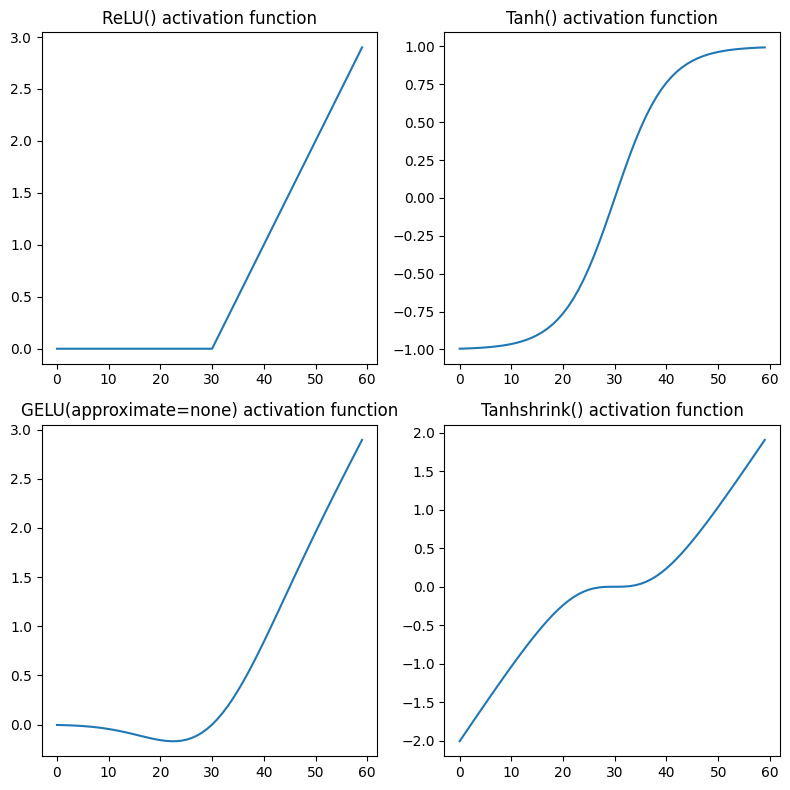

In [159]:
act_func = [torch.nn.ReLU(),
            torch.nn.Tanh(),
            torch.nn.GELU(),
            torch.nn.Tanhshrink()
           ]

fig = plt.figure(figsize=(8,8))

for i in range(len(act_func)):
            plt.subplot(2,2,i+1)
            plt.plot(act_func[i](data))
            plt.title(f"{act_func[i]} activation function")
            plt.tight_layout()
            plt.plot()

### Fitting model

The Trainer class is responsible for training the model and linking the NeuralNetwork with the Optimizer. It includes the fit method, which trains the model for a specified number of epochs. During each epoch, the data is shuffled, and batches are fed through the network for parameter updates. The Trainer class ensures that the entire training set is processed.

In [45]:
# Example of a trainer class from scratch 

class Trainer(object):
    '''
    Trains a neural network.
    '''

    def __init__(self, net: NeuralNetwork, optim: Optimizer):
        '''
        Requires a neural network and an optimizer in order for training to occur.
        Assign the neural network as an instance variable to the optimizer.
        '''
        self.net = net
        setattr(self.optim, 'net', self.net)

    def fit(self, X_train: ndarray, y_train: ndarray, X_test: ndarray, y_test: ndarray,
            epochs: int=100, eval_every: int=10, batch_size: int=32, seed: int = 1,
            restart: bool = True) -> None:
        '''
        Fits the neural network on the training data for a certain number of epochs.
        Every "eval_every" epochs, it evaluates the neural network on the testing data.
        '''
        np.random.seed(seed)
        if restart:
            for layer in self.net.layers:
                layer.first = True
        for e in range(epochs):
            X_train, y_train = permute_data(X_train, y_train)
            batch_generator = self.generate_batches(X_train, y_train, batch_size)
            for ii, (X_batch, y_batch) in enumerate(batch_generator):
                self.net.train_batch(X_batch, y_batch)
                self.optim.step()
            if (e+1) % eval_every == 0:
                test_preds = self.net.forward(X_test)
                loss = self.net.loss.forward(test_preds, y_test)
                print(f"Validation loss after {e+1} epochs is {loss:.3f}")


The code below demonstrates the process of training a network by combining the Trainer and Optimizer classes with the model and neural_network class.

In [ ]:
# Define a model 
nn_model = NeuralNetwork(
    layers=[
        Dense(neurons=25, activation=Sigmoid()),
        Dense(neurons=25, activation=Tanh()),
        Dense(neurons=1, activation=LinearAct())
    ],
    loss=MeanSquaredError(),
    learning_rate=0.01
)

In [ ]:
optimizer = SGD()
trainer = Trainer(nn_model, optimizer)
trainer.fit(X_train, y_train, X_test, y_test,
epochs = 100,
eval_every = 5,
seed=77);

In [ ]:
# In Keras this step is implemented with fit method

In [ ]:
model_0 = model.fit(
    inputs, # Examples
    targets, # Targets
    epochs=5, 
    batch_size=128
)

In [ ]:
# Model evaluation in Keras
history = model_0.evaluate(X_test,
                       y_test,
                       batch_size=BATCH_SIZE)


#### Regularization

Regularization is a set of practices that push the network to learn the relevant features of the parent distribution rather than the details of the training set. Here are some common regularization techniques:

1. **Parameter Norm Penalties**
   - L1 (Lasso) Regularization
   - L2 (Ridge) Regularization

2. **Dropout**
   - Dropout trains the ensemble consisting of all sub-networks that can be formed by removing non-output units from an underlying base network.

3. **Early Stopping**
   - Returning to the parameter setting at the point in time with the lowest validation set error.

4. **Data Augmentation**
   - Creating synthetic data and adding it to the training set.

5. **Injecting Noise at the Output Targets**
<br>
6. **Model averaging with bagging and ensembles**

### An example of end-to-end model training for binary classification with Keras 
Dataset : imdb film reviews (texts) and sentiments (positive/negative)

#### Setting up TensorBoard
TensorBoard is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space


In [2]:
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [3]:
%load_ext tensorboard

In [4]:
callbacks = keras.callbacks.TensorBoard(log_dir = log_folder,
                                        update_freq='epoch',
                                        histogram_freq = 1)

In [5]:
%tensorboard --logdir={log_folder}

In [ ]:
# Defininng model parameters

In [6]:
max_len = 400
n_words = 10000
dim_embedding = 256
epochs = 10 # the number of complete passes through the training dataset
batch_size = 300 # is a number of observations processed before the model is updated

# iterations is the number of batches needed to complete one epoch

validation_split = 0.2 # how much train dataset is reserved for validation
dropout = 0.3 # the dropout hyperparameter is the probability of training a given node in a layer (1-no dropout, 0- no output from the layer)


In [7]:
#Download the dataset containing movie reviews with binary labels (positive and negative).
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=n_words)

In [8]:
len(X_train.max())

374

In [9]:
# Lengths  of reviews
reviews = X_train[0:5]
for i in reviews:
    print(len(i))

218
189
141
550
147


In [10]:
# back to text 
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = " ".join([reverse_word_index.get(i - 3, "?") for i in X_train[2]])

In [11]:
decoded_review[:300]

'? this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started'

### Preparing data 

We can’t directly feed arbitrary lists of integers into a neural network because they all have different
lengths. While a neural network expects to process contiguous batches of data. You have to turn your lists into tensors. There are two approaches for this task: 

-  Pad your lists so that they all have the same length, turn them into an integer tensor of shape (samples, max_length), and start your model with a layer capable of handling such integer tensors (for instance, Embedding layer)

-  Multi-hot encode your lists to turn them into vectors of 0s and 1s.  Turning the list [1, 5, 10] into a 1000-dimensional vector that would be all 0s except for indices 1, 5, 10, which would be 1s. After that we can use  Dense layer, capable of handling floating-point vector data, as the first layer in our model.

Both approaches presented below

In [12]:
#Pad sequences to the same length
X_train = preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

In [13]:
reviews_padded = X_train[0:5]
for i in reviews_padded:
    print(len(i))

400
400
400
400
400


In [14]:
#Multi-hot encode approach
'''
def vectorizer(text, dimension=10000):
    vectorized = np.zeros((len(text), dimension))
    for i, text in enumerate(text):
        for j in text:
            vectorized[i, j] = 1.
    return vectorized


X_train = vectorizer(train_data)
X_test = vectorizer(test_data)
X_train[0]

# Vectorizing labels 
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32") 
''' 

'\ndef vectorizer(text, dimension=10000):\n    vectorized = np.zeros((len(text), dimension))\n    for i, text in enumerate(text):\n        for j in text:\n            vectorized[i, j] = 1.\n    return vectorized\n\n\nX_train = vectorizer(train_data)\nX_test = vectorizer(test_data)\nX_train[0]\n\n# Vectorizing labels \ny_train = np.asarray(train_labels).astype("float32")\ny_test = np.asarray(test_labels).astype("float32") \n'

In [15]:
# Build model for padded sequences
'''
The model will take as input an integer matrix of size (batch, input_length).
The model will output dimension (input_length, dim_embedding).
The largest integer in the input should be no larger than n_words (vocabulary size)'''

def build_model():
    
    model = models.Sequential([
        layers.Embedding(n_words,
                         dim_embedding,
                         input_length=max_len),
        layers.Dropout(0.4),
        layers.GlobalMaxPooling1D(),# Takes the maximum value of either feature vector from each of the n_words features.
        layers.Dense(128,
                     activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1,
                     activation='sigmoid')
    ])
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

In [16]:
# Train model
model = build_model()
model.summary()
history = model.fit(X_train,
                  y_train,
                  epochs = epochs,
                  batch_size = batch_size,
                  validation_data = (X_test, y_test),
                  callbacks=callbacks
                 )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 256)          2560000   
                                                                 
 dropout (Dropout)           (None, 400, 256)          0         
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [484]:
# Model evaluation. Test loss, accuracy
test_loss, test_acc = model.evaluate(X_test,
                                     y_test,
                                     batch_size=batch_size)

print(f'Test Loss: {test_loss}\nTest Accuracy :{test_acc}')

84/84 [==============================] - 1s 10ms/step - loss: 0.3014 - accuracy: 0.8721
Test Loss: 0.30139943957328796
Test Accuracy :0.8720800280570984


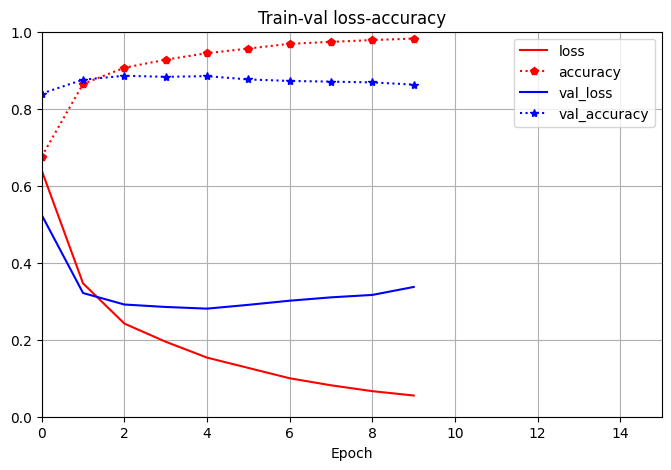

In [322]:
# Model evaluation. Train vs test loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5),
                                 xlim=[0, 15],
                                 ylim=[0, 1],
                                 grid=True,
                                 xlabel="Epoch",
                                 style=["r", "r:p", "b-", "b:*"])
plt.title('Train-val loss-accuracy')
plt.show()

In [235]:
# Making predictions
predictions = model.predict(X_test)
predictions.round(2)[:10]
# Conversion to binary values  
# predictions=np.rint(predictions) 

782/782 [==============================] - 1s 1ms/step


array([[0.04],
       [1.  ],
       [0.82],
       [0.83],
       [0.99],
       [0.96],
       [0.74],
       [0.1 ],
       [0.99],
       [0.99]], dtype=float32)

In [290]:
# model evaluation with the ROC curve, confusion matrix, and classification report

def classifier_evaluation(model, X_test, y_test):
    # Predict using the model
    predictions = model.predict(X_test)
    
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_test, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    
    # Create subplots for ROC curve and confusion matrix
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
    
    # Plot ROC curve
    ax1.plot(fpr, tpr, label='Neural network (AUC = {:.2f})'.format(roc_auc))
    ax1.plot([0, 1], [0, 1], 'g--')
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend(loc='lower right')
    
    # Convert predictions to binary values
    predictions = np.rint(predictions)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, predictions)
    
    # Define labels and counts for confusion matrix
    labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    names = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(labels, counts, percentages)]
    names = np.asarray(names).reshape(2, 2)
    
    # Plot confusion matrix as heatmap
    sns.heatmap(cm, annot=names, cmap='crest', fmt='', ax=ax2)
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
    ax2.set_title('Confusion Matrix')
    
    # Adjust spacing between subplots
    fig.tight_layout()
    
    # Print classification report
    print('\tClassification Report:\n\n', classification_report(y_test, predictions, target_names=['Negative', 'Positive']))


782/782 [==============================] - 1s 1ms/step
	Classification Report:

               precision    recall  f1-score   support

    Negative       0.86      0.87      0.87     12500
    Positive       0.87      0.86      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



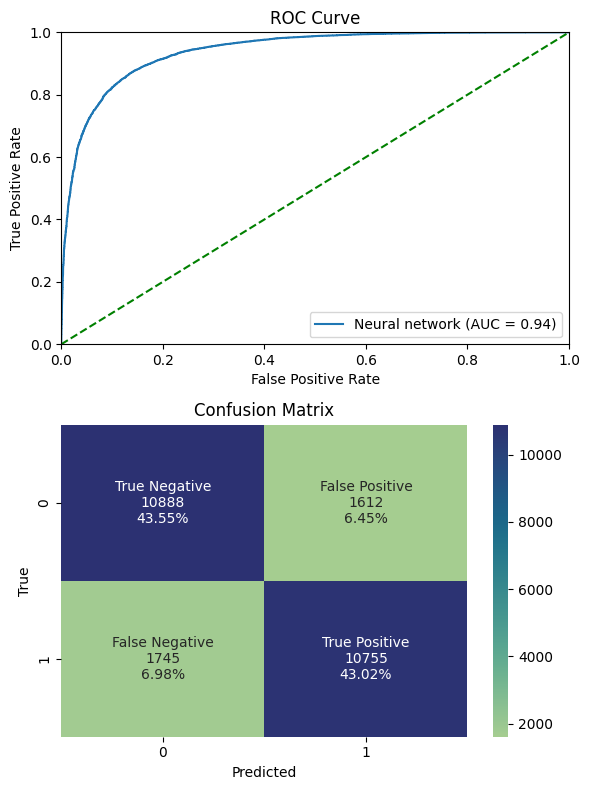

In [291]:
classifier_evaluation(model, X_test, y_test)

In [404]:
# Model for multi-hot encode approach

In [416]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=n_words)

In [417]:
# Vectorize reviews
def vectorizer(text, dimension=10000):
    vectorized = np.zeros((len(text), dimension))
    for i, text in enumerate(text):
        for j in text:
            vectorized[i, j] = 1.
    return vectorized

In [418]:
X_train = vectorizer(train_data)
X_test = vectorizer(test_data)
X_train[0]

# Vectorizing labels 
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32") 

In [419]:
def build_model():
    model = models.Sequential([
        layers.Dense(32, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer = "SGD",
                  loss = "binary_crossentropy",
                  metrics = ["accuracy"])
    return model

In [420]:
model = build_model()
history = model.fit(X_train,
                  y_train,
                  epochs = epochs,
                  batch_size = batch_size,
                  verbose=0,
                  validation_data = (X_test, y_test)
                 )

#### K-Fold Cross Validation

K-Fold Cross-validation. It is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. The purpose of cross–validation is to test the ability of a machine learning model to predict on unseen data.

In [423]:
k = 5
num_val_samples = len(X_train) // k
num_epochs = 10
all_scores = []

for i in range(k):
    print(f"Processing fold #{i}")
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_labels[i * num_val_samples: (i + 1) * num_val_samples]
    
    X_train = np.concatenate([
        X_train[:i * num_val_samples],
        X_train[(i + 1) * num_val_samples:]
    ], axis=0)
    
    y_train = np.concatenate([
        y_train[:i * num_val_samples],
        y_train[(i + 1) * num_val_samples:]
    ], axis=0)
    
    model = model_builder()
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=256, verbose=0)
    
    val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)
    
    all_scores.append(val_acc)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
Processing fold #4


In [424]:
all_scores

[0.8730000257492065,
 0.8691999912261963,
 0.8633599877357483,
 0.8640000224113464,
 0.8629199862480164]

### PyTorch

### Preparing data with PyTorch Dataset and Dataloader 

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. 
PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. 

- Dataset stores the samples and their corresponding labels  
- DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

#### Generate dataset

In [ ]:
def generate_image_folder_dataset(dataset, target_path, csv_path):
    
    images_counter = Counter()
    files = []
    labels = []

    for image, label in tqdm(dataset):
        class_folder = target_path + "/" + str(label)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder, exist_ok=True)

        images_counter[label] += 1
        file_name = f"/{images_counter[label]:05}.png"
        full_image_file_name = class_folder + file_name

        files.append(str(label) + file_name)
        labels.append(label)

        image = np.array(image)
        image = (image * 255).astype(np.uint8)
        image = np.transpose(image, [1, 2, 0])
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        # print(image.dtype)
        # print(image.shape)
        cv2.imwrite(full_image_file_name, image)

        
    pd.DataFrame({ "image": files, "label": labels }).to_csv(csv_path, index=False)

generate_image_folder_dataset( mnist_train,  "./MNIST_image_folder/train", "MNIST_image_folder/train.csv" )
generate_image_folder_dataset( mnist_val,  "./MNIST_image_folder/val", "MNIST_image_folder/val.csv" )

In [ ]:
Customized Dataset 

class DatasetMNIST(Dataset):
    def __init__(self, root='./MNIST_image_folder', train=True, transform=None):
        
        self.train = train
        self.transform = transform

        subdir = 'train' if train else 'val'
        self.root = root + '/' + subdir

        csv_path = 'train.csv' if train else 'val.csv'
        self.dataset_index = pd.read_csv(root + '/' + csv_path)


    def __len__(self):
      return len(self.dataset_index)
        

    def __getitem__(self, index):
        # load image, transform image, return dict with image and class label
        sample = self.dataset_index.iloc[index]
        image_path = sample['image']
        label = sample['label']

        fullimage_path = self.root + '/' +image_path
        image = cv2.imread(fullimage_path,0)

        if self.transform:
          image = self.transform(image)
        else:
          image = image[None, ...] / 255


        return {
            'image': image,
            'label': label
        }

In [ ]:
# Test for the cumstom Dataset

def test_dataset(dataset, test_name=""):

    assert len(dataset) > 0, f"{test_name}: dataset length is greater then zero"

    idateset = iter(dataset)
    item = next(idateset)

    assert isinstance(item, dict), f"{test_name}: dataset returned dict"
    assert "image" in item, f"{test_name}: dataset item dict has image"
    assert "label" in item, f"{test_name}: dataset item dict has label"

    assert item['image'].shape == (1, 28, 28), f"{test_name}: dataset image shape is correct. Got: {item['image'].shape}"

mydataset = DatasetMNIST(train=False, transform=transform_to_tensor)
test_dataset(mydataset, test_name="val")

mydataset = DatasetMNIST(train=True, transform=transform_to_tensor)
test_dataset(mydataset, test_name="train")